In [1]:
# pip install tensorflow
# pip install alpha_vantage

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from alpha_vantage.foreignexchange import ForeignExchange 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta

In [3]:
api_key = "968U93YONJTBSCFS"   #My Api Key
fx = ForeignExchange(key= "api_key", output_format="pandas")  # Initialize the ForeignExchange class

In [4]:
# Get the daily exchange rates
original_data, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="KES", outputsize="full")

In [5]:
# Renaming columns
original_data.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [6]:
original_data.index = pd.to_datetime(original_data.index)  # Convert index to datetime
original_data = original_data.sort_index() 

In [7]:
data = original_data

In [8]:
data.head()

,Open,High,Low,Close
date,,,,
2014-11-07,89.70,89.75,89.60,89.70
2014-11-10,89.70,89.75,89.60,89.75
2014-11-11,89.95,89.95,89.95,89.95
2014-11-12,89.95,90.05,89.95,90.00
2014-11-13,90.00,90.15,90.00,90.15


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2566 entries, 2014-11-07 to 2024-09-10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2566 non-null   float64
 1   High    2566 non-null   float64
 2   Low     2566 non-null   float64
 3   Close   2566 non-null   float64
dtypes: float64(4)
memory usage: 100.2 KB


In [10]:
# Summary statistics
data.describe()

,Open,High,Low,Close
count,2566.000000,2566.000000,2566.000000,2566.000000
mean,110.467783,110.651539,110.278640,110.483878
std,14.809767,14.841160,14.747865,14.809398
min,89.700000,89.750000,89.600000,89.700000
25%,101.300000,101.400000,101.150000,101.280000
50%,103.500000,103.700000,103.350000,103.500000
75%,114.487500,114.725000,114.412500,114.612500
max,162.980000,163.250000,162.280000,162.980000


In [11]:
df = data.loc['2024':]

In [12]:
df = df["Close"]
df = pd.DataFrame(data=df)

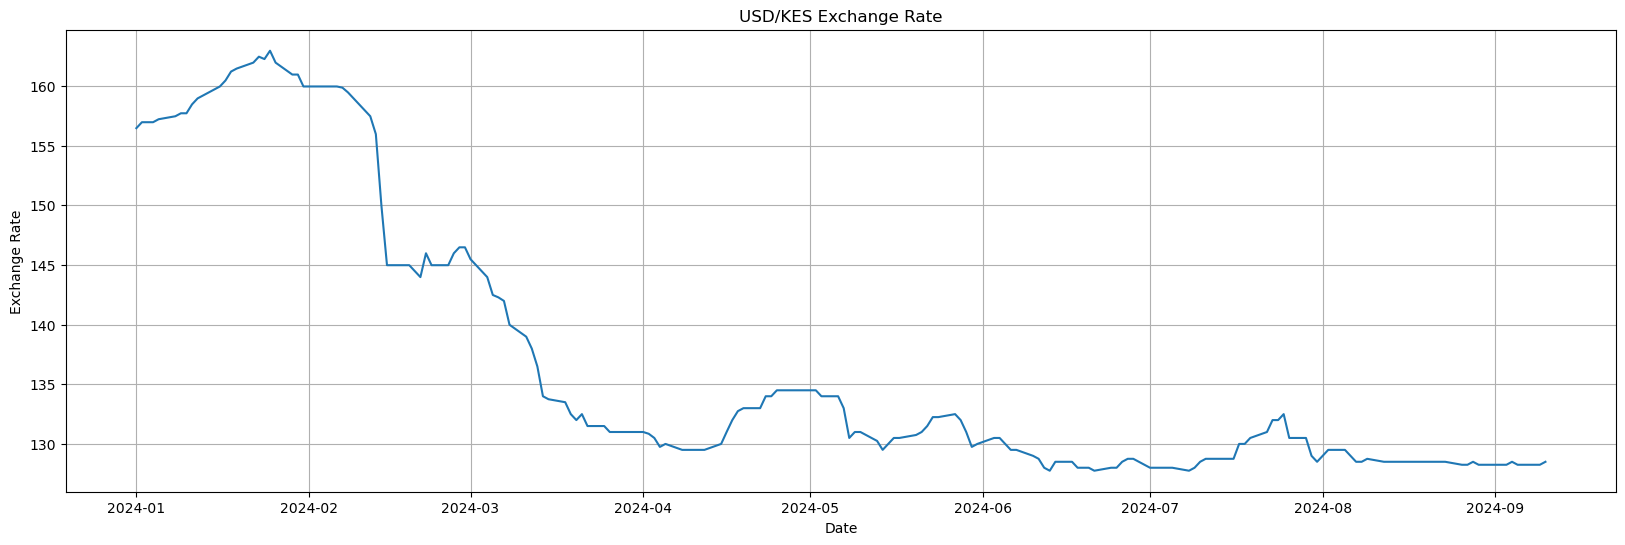

In [13]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [14]:
# Resample the data to include all the days
daily_data = df.resample('D').last()

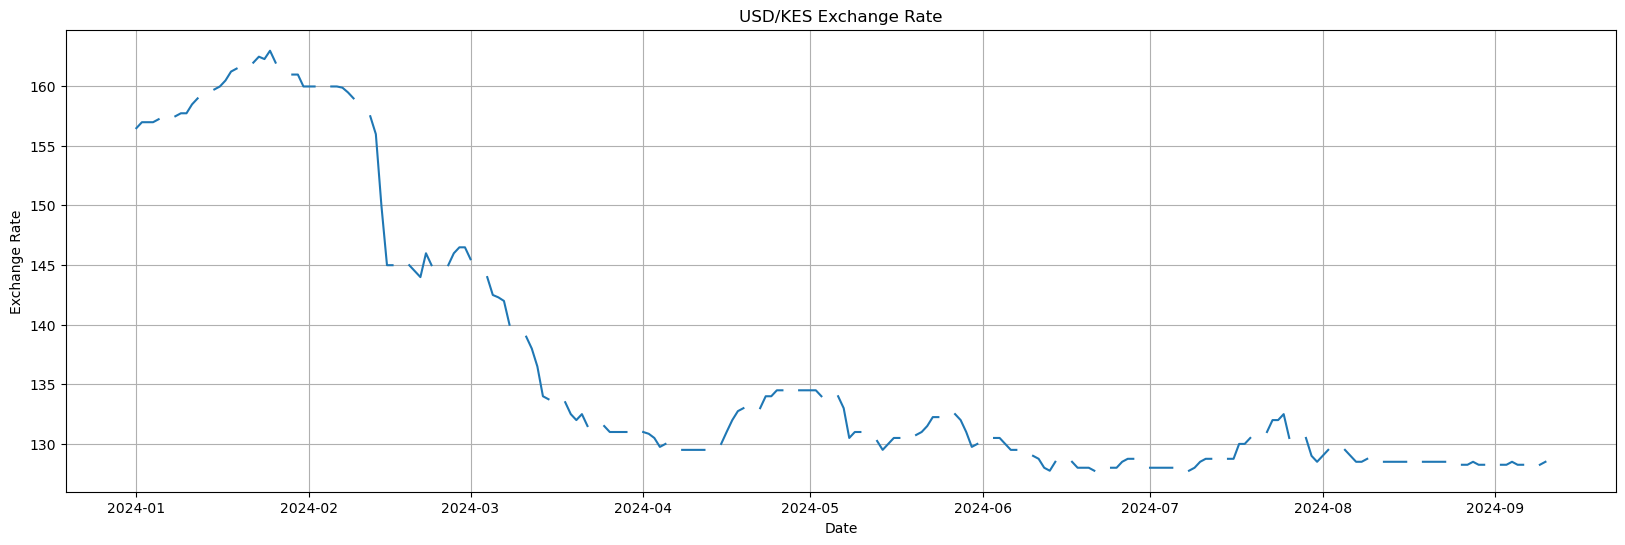

In [15]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [16]:
# interpolate the data to include weekends
filled_data = daily_data.interpolate(method='linear')

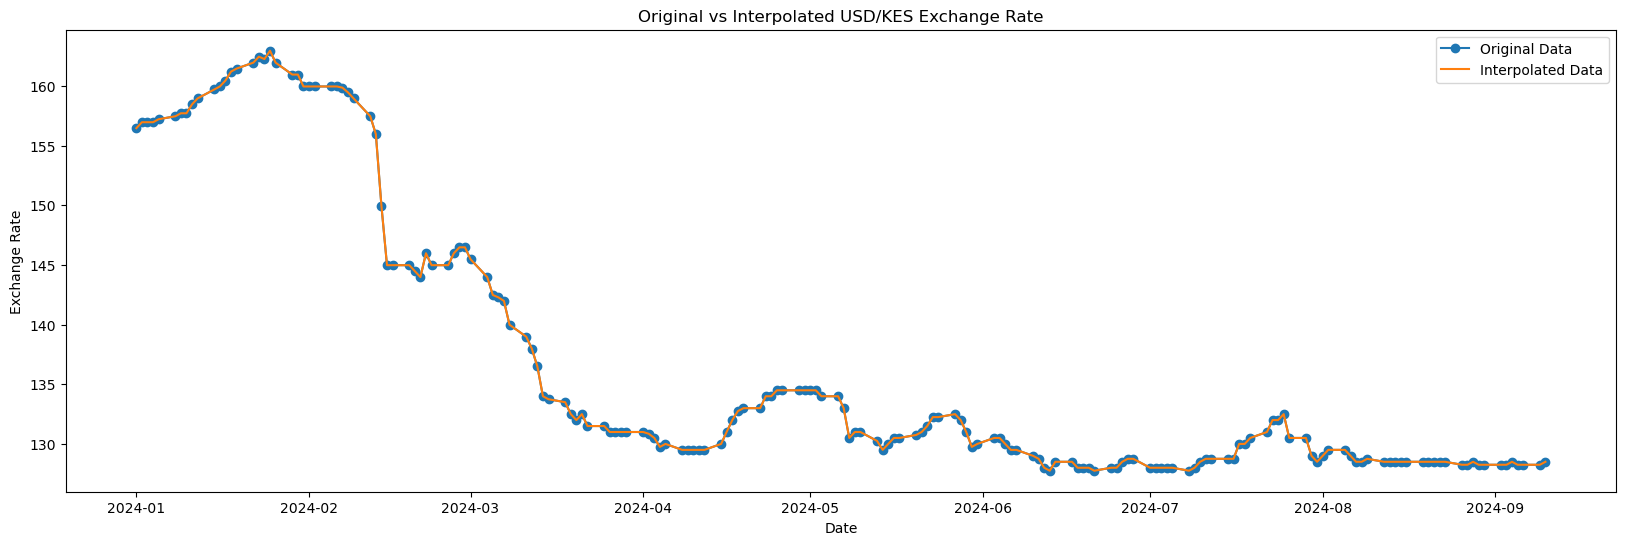

In [17]:
# Plot original vs filled data
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Close'], label='Original Data', marker='o')
plt.plot(filled_data.index, filled_data['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Stationarity Check

In [18]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.6904356930183142
p-value: 0.4360469105882147
The series is non-stationary, differencing is required.


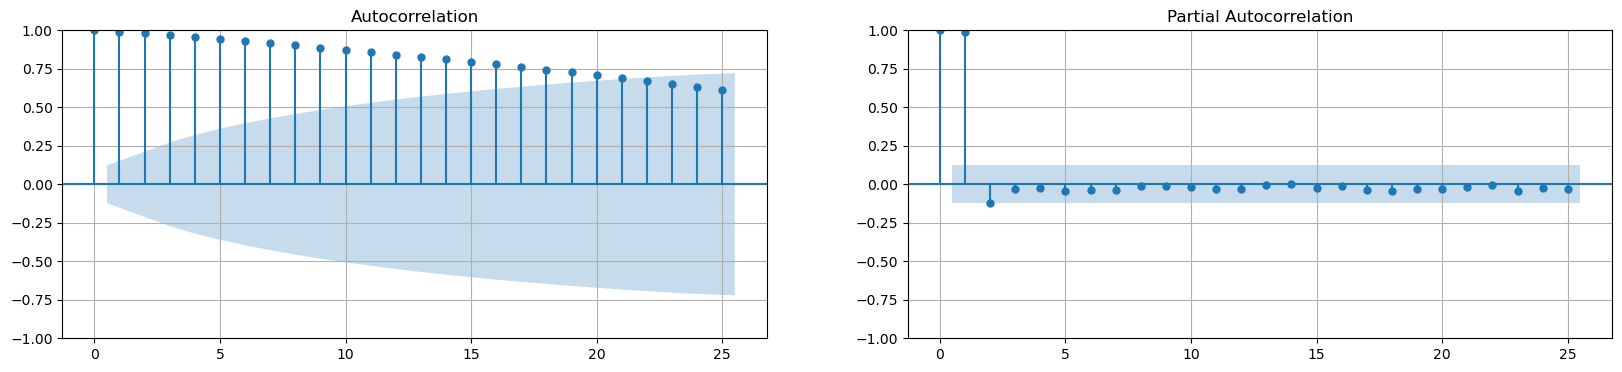

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_data, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_data, ax=axes[1])
axes[1].grid(True)
plt.show()

ACF is not deminishing

#  Prepare data for modeling

## Split the filled data into train and test sets

In [20]:
# Split the filled data into train and test sets
train_size = int(len(filled_data) * 0.95)
train, test = filled_data[:train_size], filled_data[train_size:]

In [21]:
print("Train: ",train.shape)
print("Test : ",test.shape)

Train:  (241, 1)
Test :  (13, 1)


## Decomposition

In [22]:
add_decomp = seasonal_decompose(train, model="additive")

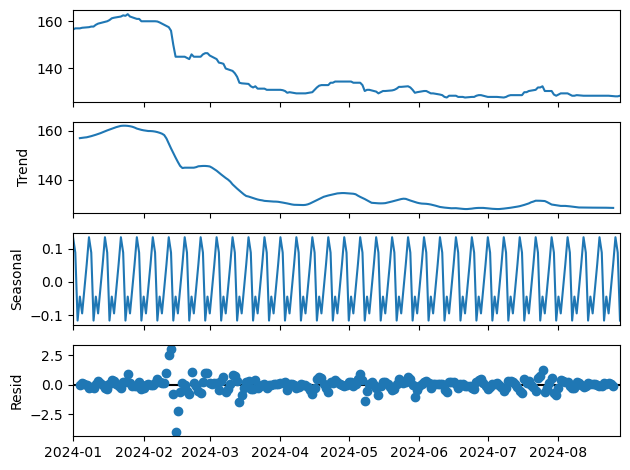

In [23]:
add_decomp.plot()
plt.show()

- there is a trend in the data
- the data is also seasonal
- there is also White noise

## Augmented Dickey-Fuller (ADF) test 

In [24]:
adf_results = sts.adfuller(train)
#adf_results

In [25]:
adf_statistic = adf_results[0]
p_value = adf_results[1]
usedlag = adf_results[2]
nobs = adf_results[3]
critical_values = adf_results[4]
icbest = adf_results[5]

In [26]:
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.606360172698028
p-value: 0.4803978400694281
Number of Lags Used: 1
Number of Observations Used: 239
Critical Values:
	1%: -3.458010773719797
	5%: -2.8737103617125186
	10%: -2.5732559963936206


Based on the ADF test results, 

- Test statistic: The ADF statistic is higher (less negative) than all the critical values.
- p-value: The p-value is greater than the common significance levels (0.01, 0.05, and 0.10).
- Stationarity: Given that the test statistic is higher than the critical values and the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root. This suggests that the time series is likely non-stationary.
- Critical values: Since the test statistic is less negative than all these critical values, it supporting the conclusion of non-stationarity.
- Sample size: Is a relatively large sample size, lending reliability to the results.
- Lag selection: 28 lags were used in the test, which helps account for potential autocorrelation in the residuals.

In conclusion, this time series appears to be non-stationary based on the ADF test results. Further differencing or transformation is necessary to achieve stationarity before proceeding with certain time series analyses or models.

# Modeling


## Differencing the Series

In [27]:
diff = train.diff().dropna()

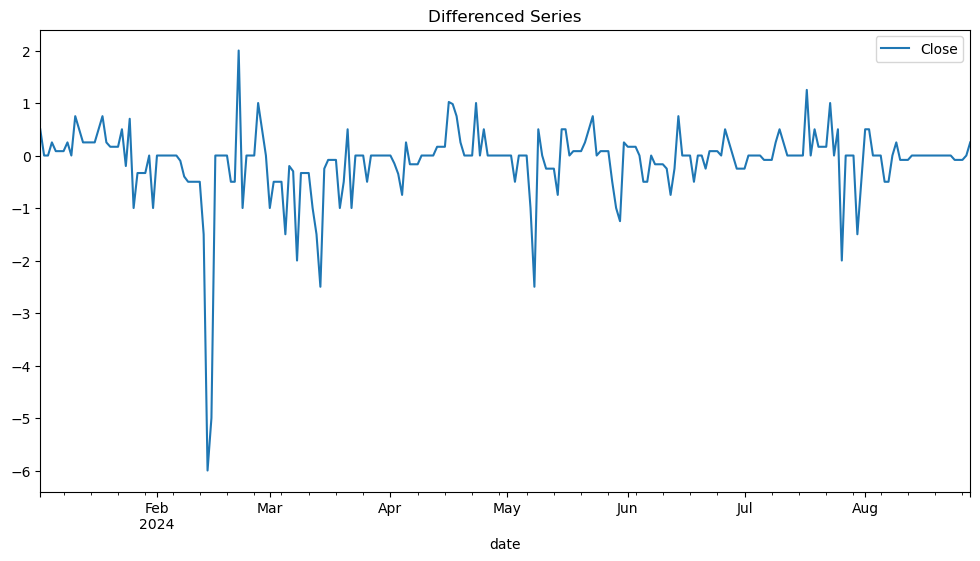

In [28]:
# Plot the differenced series
diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

In [29]:
# Perform the ADF test on the differenced series
adf_result_diff = adfuller(diff)
print('ADF Statistic after Differencing:', adf_result_diff[0])
print('p-value after Differencing:', adf_result_diff[1])
print('Number of Lags Used:', adf_result_diff[2])
print('Number of Observations Used:', adf_result_diff[3])
print('Critical Values after Differencing:', adf_result_diff[4])

ADF Statistic after Differencing: -9.81745629416564
p-value after Differencing: 5.4494797236699435e-17
Number of Lags Used: 0
Number of Observations Used: 239
Critical Values after Differencing: {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}


Deductions
- Since the p-value is now lower than 0.005 and the ADF statistic is more negative than the critical values indicate that the time series has become stationary after differencing. 
- Applying one difference (d=1) was sufficient to make the series stationary.

## Proceeding to identify the appropriate values for p and q by analyzing the ACF and PACF plots.

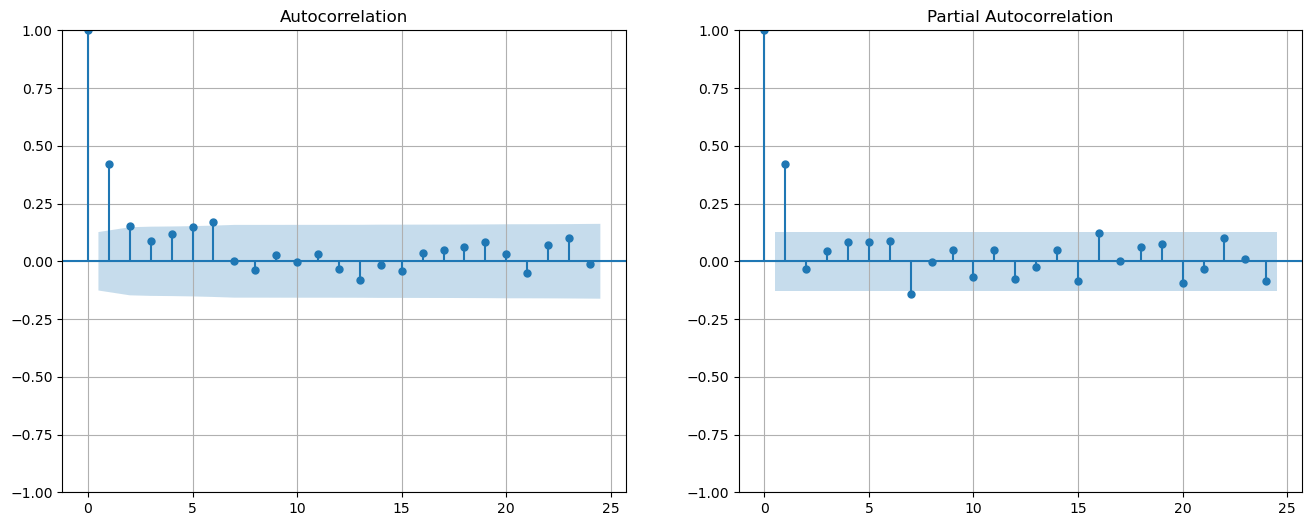

In [30]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff, ax=axes[1])
axes[1].grid(True)
plt.show()

- p = 1
- d = 1
- q = 1
- m = 7

# Model selection

## 1. ARIMA

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p, d, q with the values identified from ACF and PACF
model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit()

c:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [32]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  241
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -240.498
Date:                Tue, 10 Sep 2024   AIC                            488.996
Time:                        17:46:47   BIC                            502.919
Sample:                    01-01-2024   HQIC                           494.606
                         - 08-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1539      2.556      0.060      0.952      -4.857       5.164
ar.L2          0.0999      1.135      0.088      0.930      -2.125       2.325
ma.L1          0.2963      2.552      0.116      0.9

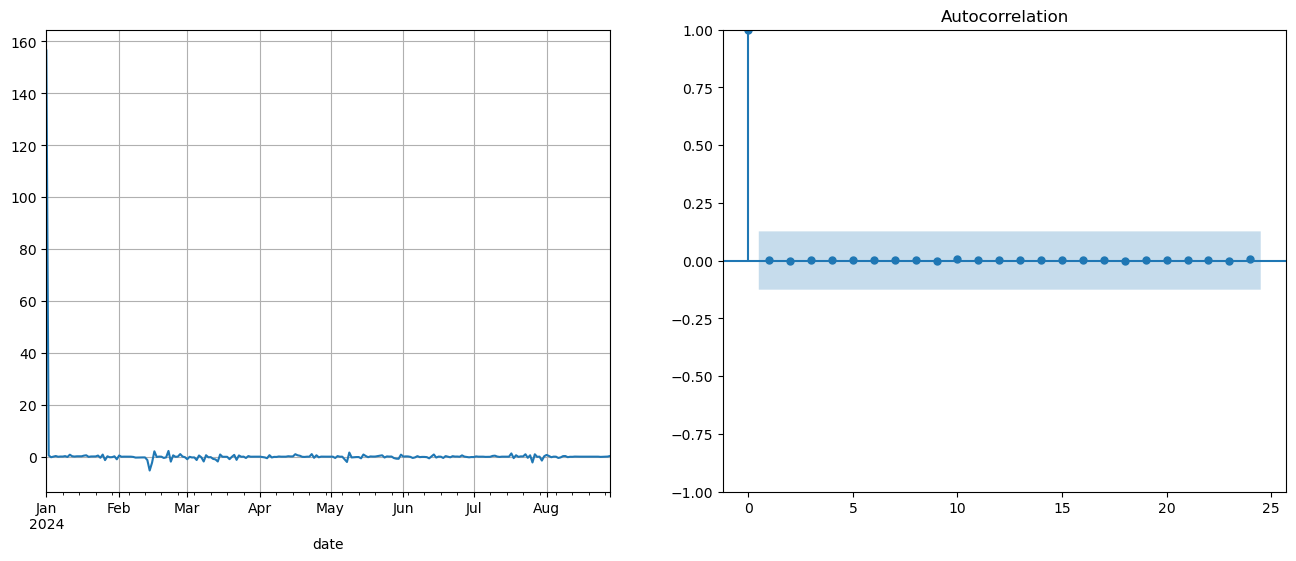

In [33]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot residuals
residuals.plot(ax=axes[0])
axes[0].grid(True)
# Plot ACF of residuals
plot_acf(residuals, ax=axes[1])

plt.show()

In [34]:
predictions = model_fit.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)

In [36]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.1565932129867167


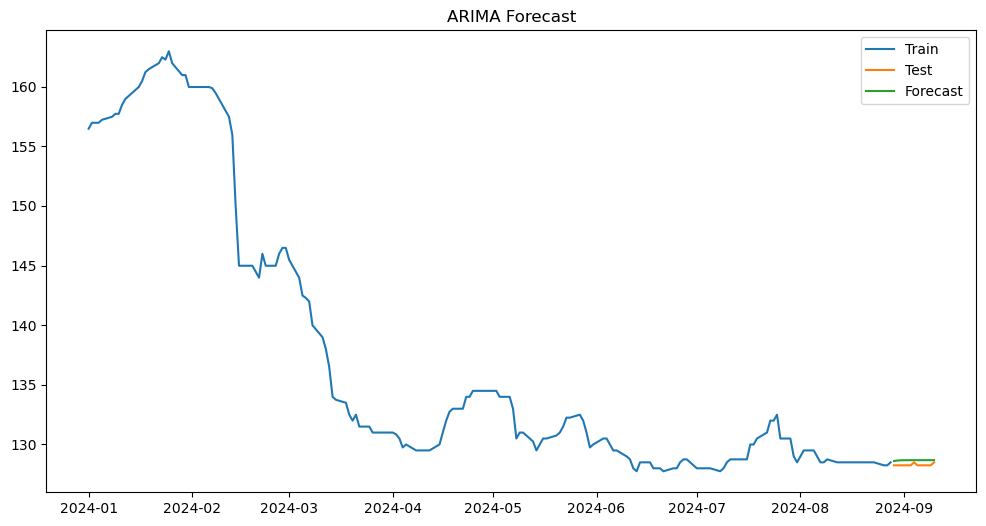

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## 2. SARIMA


In [38]:
p, d, q = 1, 1, 1

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted = model_s.fit() 


In [40]:
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -244.471
Date:                           Tue, 10 Sep 2024   AIC                            498.942
Time:                                   17:47:07   BIC                            516.197
Sample:                               01-01-2024   HQIC                           505.900
                                    - 08-28-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3659      0.095      3.835      0.000       0.179       0.553
ma.L1          0.0966      0.126      0.764

In [41]:
from sklearn.metrics import mean_squared_error

# Get the predicted values
predictions2 = fitted.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)


In [42]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.20304494417911584


In [43]:
test.tail()

,Close
date,
2024-09-06,128.23
2024-09-07,128.23
2024-09-08,128.23
2024-09-09,128.23
2024-09-10,128.48


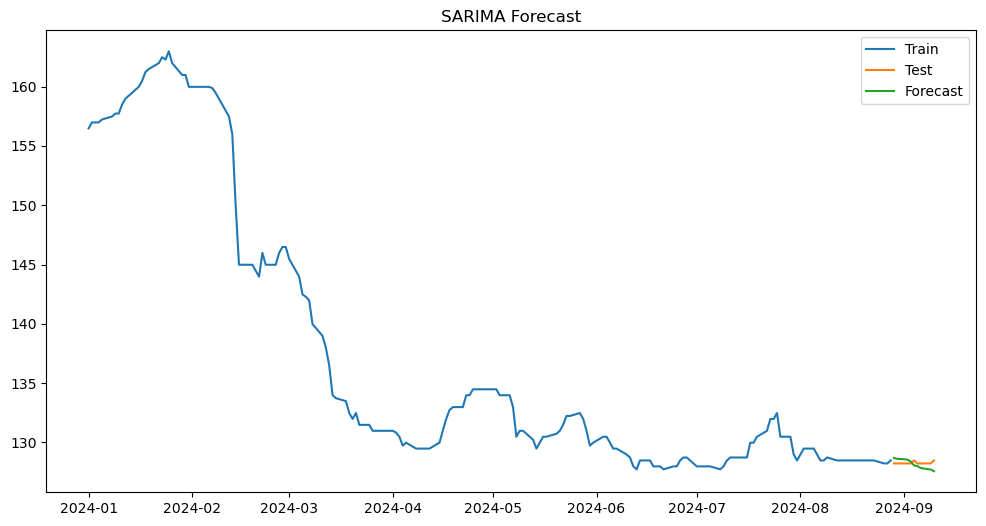

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## 3. LSTM Model

In [45]:
close_data = original_data[['Close']].loc['2019':] 
dates = close_data.index               # Extracting dates from the DataFrame

In [46]:
close_values = close_data.values     # Convert the 'Close' column to NumPy array for processing

Data Preprocessing

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))       # Normalize the data using MinMaxScaler
scaled_data = scaler.fit_transform(close_values)

In [48]:
# Function to create sequences of data (X, y) pairs
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [49]:
time_step = 60                                      # Define time step for the sequences
X, y = create_sequences(scaled_data, time_step)     # Create sequences
X = X.reshape((X.shape[0], X.shape[1], 1))          # Reshape X to be [samples, time steps, features] for LSTM

In [50]:
# Split data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [51]:
print("X_train shape is...", X_train.shape)
print("X_test shape is....", X_test.shape)
print("y_train shape is...", y_train.shape)
print("y_test shape is....", y_test.shape)

X_train shape is... (1140, 60, 1)
X_test shape is.... (285, 60, 1)
y_train shape is... (1140,)
y_test shape is.... (285,)


Splitting the dates accordingly

In [52]:
dates_train = dates[time_step:split + time_step]  # Adjust to match the training data length
dates_test = dates[split + time_step:]            # Adjust to match the test data length

Create the LSTM Model

In [53]:

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0203 - val_loss: 0.0026
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.3829e-04 - val_loss: 0.0028
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 9.4875e-05 - val_loss: 0.0030
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 7.3265e-05 - val_loss: 0.0028
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.5696e-05 - val_loss: 0.0033
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 7.6634e-05 - val_loss: 0.0027
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.4432e-05 - val_loss: 0.0023
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.7925e-05 - val_loss: 0.0025
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.0163e-05 - val_loss: 0.0024
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.3166e-05 - val_loss: 0.0026
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.6573e-05 - val_loss: 0.0021
Epoch 12/20
36/36 ━━━━━

In [56]:
# Make Predictions
predicted = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


In [57]:
# Inverse transform the predictions and actual values to original scale for comparison
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

Predicting the future

In [58]:
future_days = 14

In [59]:
last_sequence = X_test[-1]  # last sequence from the test set

Make predictions for the next 'future_days'

In [60]:
future_predictions = []
current_sequence = last_sequence

for i in range(future_days):
    next_value = model.predict(current_sequence.reshape(1, time_step, 1))   # Predict the next value
    future_predictions.append(next_value[0, 0])                             # Append the prediction to the future predictions list
    current_sequence = np.append(current_sequence[1:], next_value, axis=0)  # Update the current sequence by removing the first element and adding the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [61]:
# Scale back the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Generating future dates for the next 14 days

In [62]:
last_date = dates_test[-1]  # Last date from the test set
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

Plotting 

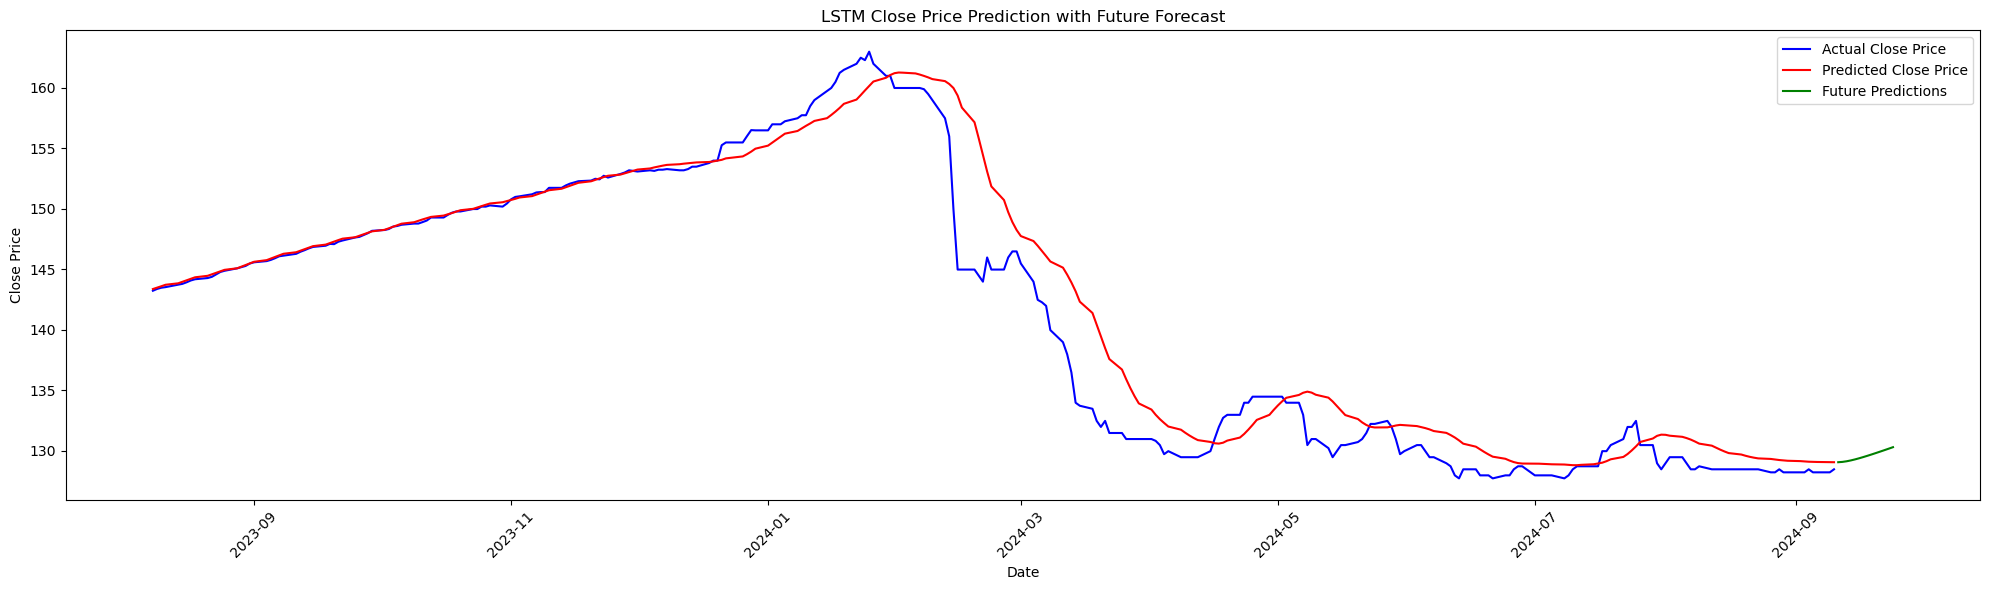

In [63]:
plt.figure(figsize=(20, 6))

plt.plot(dates_test, y_test_scaled, color='blue', label='Actual Close Price')
plt.plot(dates_test, predicted, color='red', label='Predicted Close Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')

plt.title('LSTM Close Price Prediction with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
print(len(future_predictions))
print(len(future_dates))

14
14


In [65]:
future_predictions = np.array(future_predictions).flatten()    # Ensuring that the arrays are 1-dimensional
future_dates = np.array(future_dates).flatten()

df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions
})

df['Date'] = pd.to_datetime(df['Date'])

print(df)

         Date  Predicted_Close
0  2024-09-11       129.065918
1  2024-09-12       129.092026
2  2024-09-13       129.143860
3  2024-09-14       129.214813
4  2024-09-15       129.299744
5  2024-09-16       129.394806
6  2024-09-17       129.497208
7  2024-09-18       129.604950
8  2024-09-19       129.716614
9  2024-09-20       129.831223
10 2024-09-21       129.948105
11 2024-09-22       130.066742
12 2024-09-23       130.186829
13 2024-09-24       130.308121


# USD TO UGX

In [66]:
# Get the daily exchange rates
data2, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="UGX", outputsize="full")

In [67]:
# Renaming columns
data2.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [68]:
data2 = data2.sort_index()

In [69]:
df2 = data2.loc['2024':]

In [70]:
df2.head()

,Open,High,Low,Close
date,,,,
2024-01-01,3777.2,3777.2,3777.2,3777.2
2024-01-02,3777.2,3777.2,3776.8,3776.8
2024-01-03,3776.8,3801.8,3776.8,3801.8
2024-01-04,3801.8,3801.8,3797.5,3797.5
2024-01-05,3797.5,3797.5,3787.4,3787.4


In [71]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2024-01-01 to 2024-09-10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    181 non-null    float64
 1   High    181 non-null    float64
 2   Low     181 non-null    float64
 3   Close   181 non-null    float64
dtypes: float64(4)
memory usage: 7.1 KB


In [72]:
df2 = df2["Close"]
df2 = pd.DataFrame(data=df2)

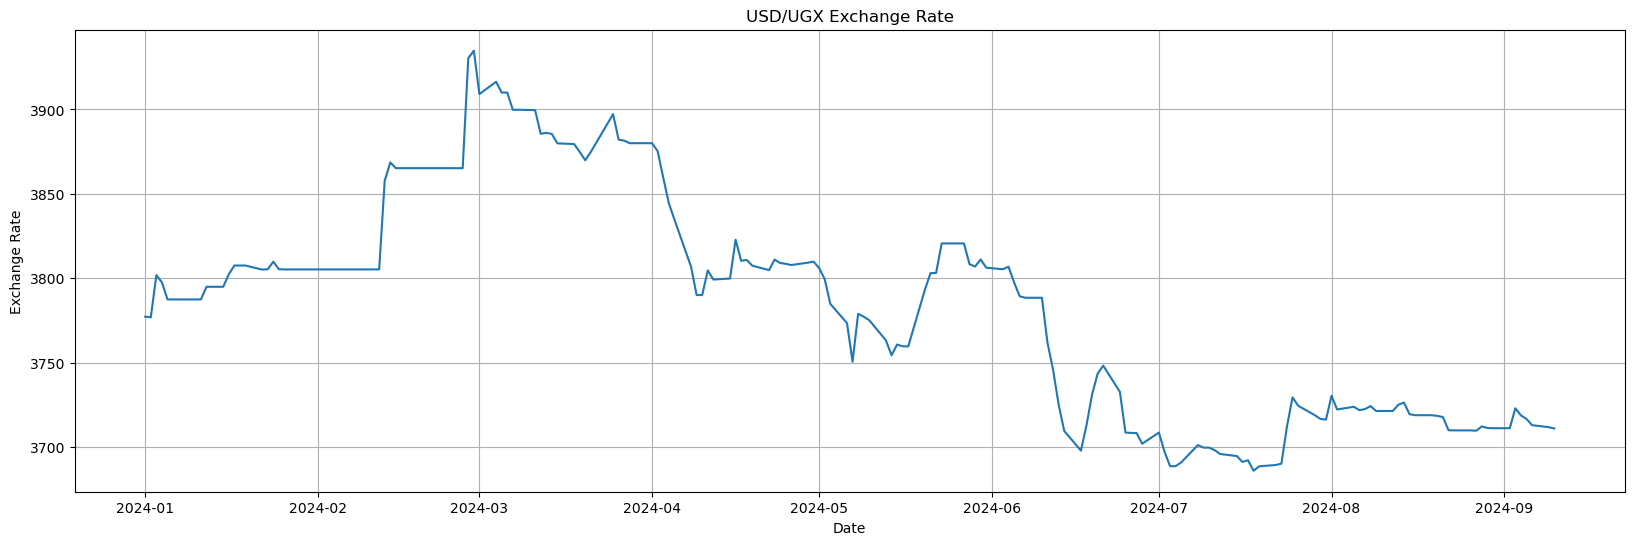

In [73]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df2['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [74]:
# Resample the data to include all the days
daily_df = df2.resample('D').last()

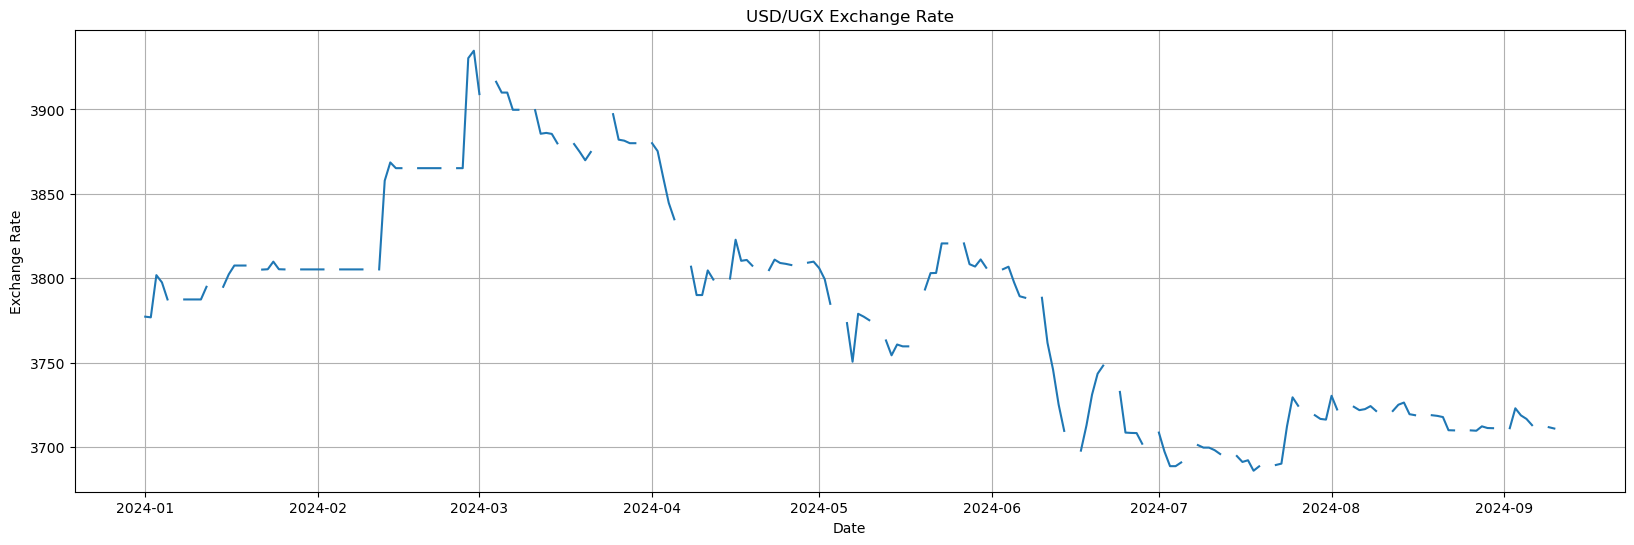

In [75]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(daily_df['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [76]:
# interpolate the data to include weekends
filled_df = daily_df.interpolate(method='linear')

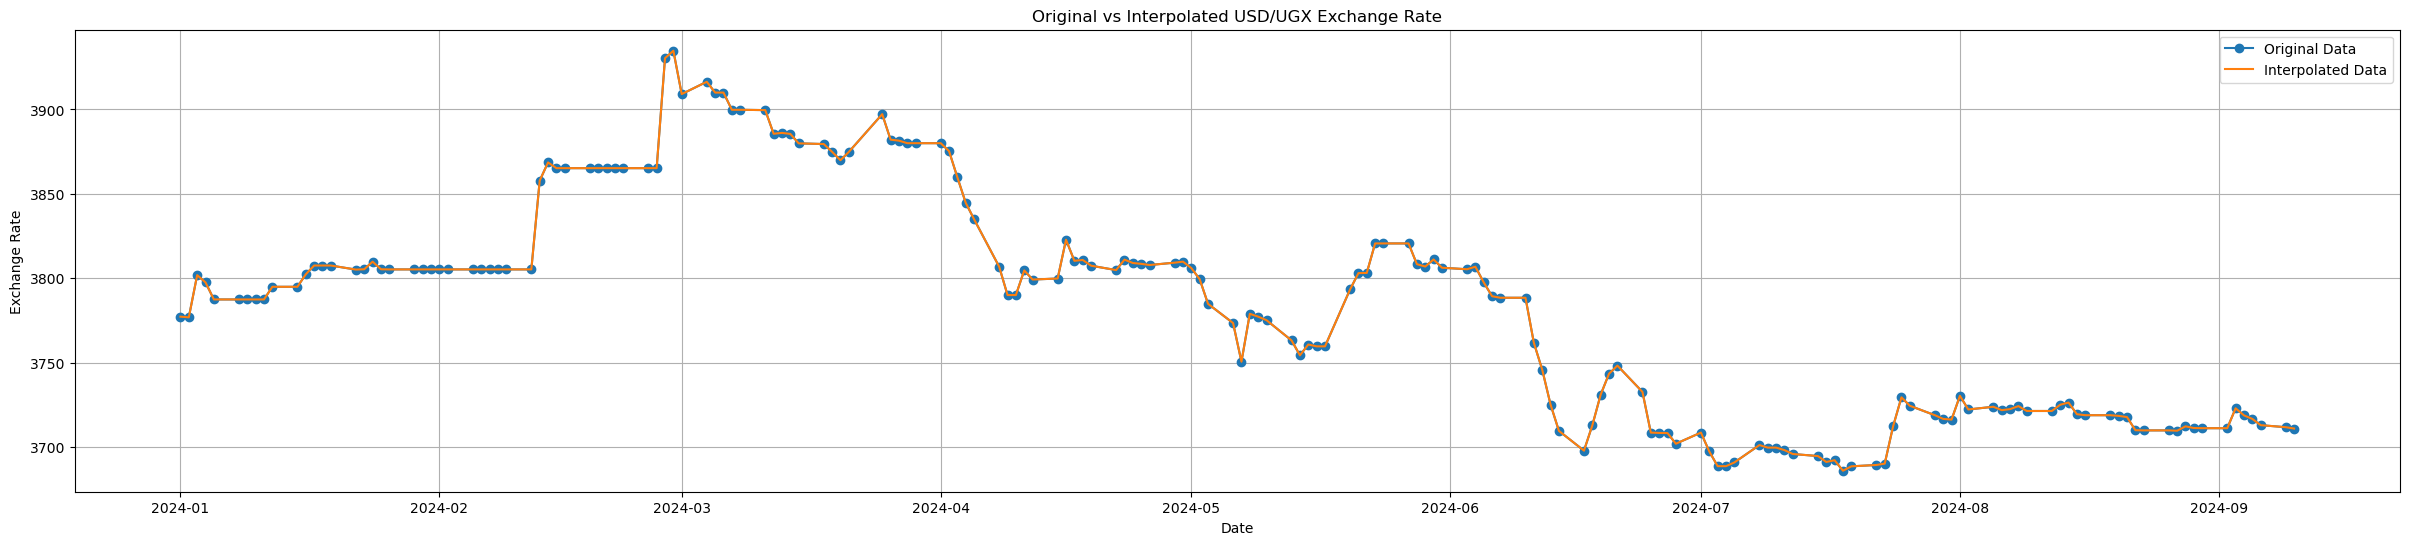

In [77]:
# Plot original vs filled data
plt.figure(figsize=(30, 6))
plt.plot(df2.index, df2['Close'], label='Original Data', marker='o')
plt.plot(filled_df.index, filled_df['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.legend()
plt.show()

In [78]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_df['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.019183522908126
p-value: 0.7462034099839796
The series is non-stationary, differencing is required.


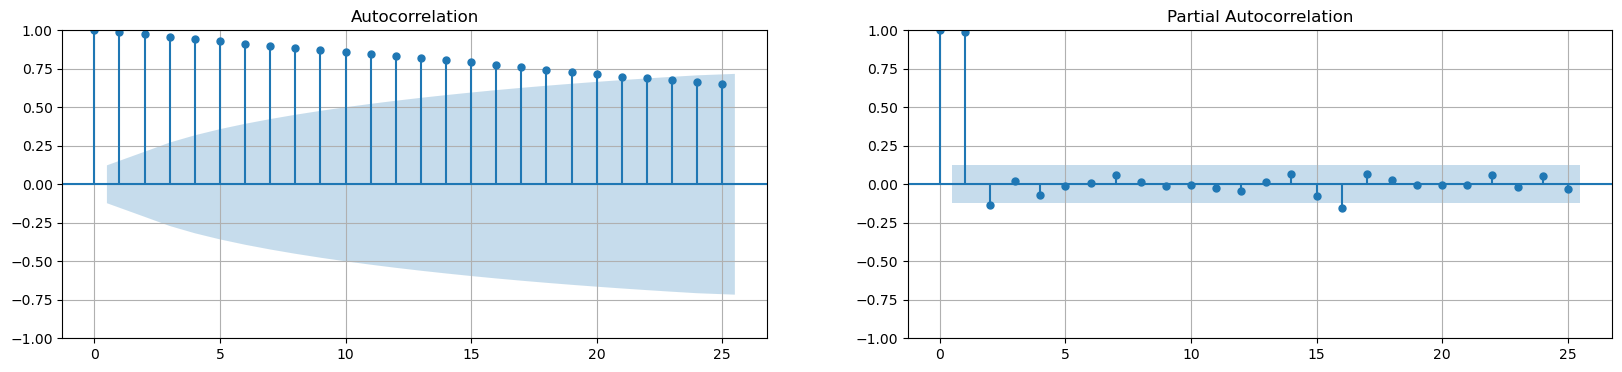

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_df, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_df, ax=axes[1])
axes[1].grid(True)
plt.show()

In [80]:
# Split the filled data into train and test sets
train_size2 = int(len(filled_df) * 0.95)
train2, test2 = filled_df[:train_size2], filled_df[train_size2:]

In [81]:
print("Train: ",train2.shape)
print("Test : ",test2.shape)

Train:  (241, 1)
Test :  (13, 1)


In [82]:
add_decomp2 = seasonal_decompose(train2, model="additive")

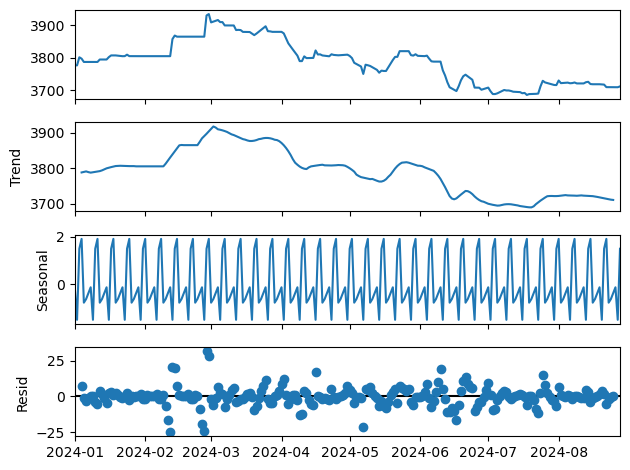

In [83]:
add_decomp2.plot()
plt.show()

In [84]:
import statsmodels.tsa.stattools as sts
adf_results2 = sts.adfuller(train2)
#adf_results

In [85]:
adf_statistic = adf_results2[0]
p_value = adf_results2[1]
usedlag = adf_results2[2]
nobs = adf_results2[3]
critical_values = adf_results2[4]
icbest = adf_results2[5]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')


ADF Statistic: -1.015711862220665
p-value: 0.7474907127275536
Number of Lags Used: 1
Number of Observations Used: 239
Critical Values:
	1%: -3.458010773719797
	5%: -2.8737103617125186
	10%: -2.5732559963936206


In [86]:
diff2 = train2.diff().dropna()

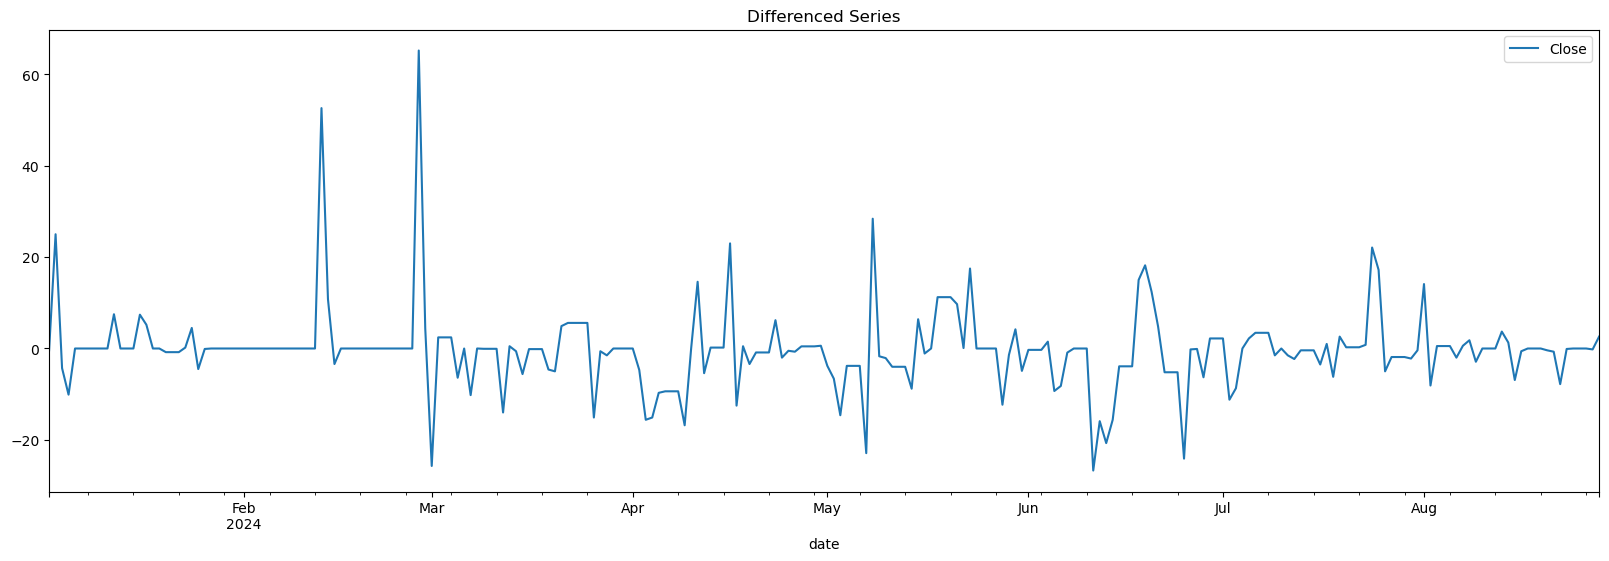

In [87]:
# Plot the differenced series
diff2.plot(figsize=(20, 6))
plt.title('Differenced Series')
plt.show()

In [88]:
# Perform the ADF test on the differenced series
adf_result_diff2 = adfuller(diff2)
print('ADF Statistic after Differencing:', adf_result_diff2[0])
print('p-value after Differencing:', adf_result_diff2[1])
print('Number of Lags Used:', adf_result_diff2[2])
print('Number of Observations Used:', adf_result_diff2[3])
print('Critical Values after Differencing:', adf_result_diff2[4])

ADF Statistic after Differencing: -12.981814247600955
p-value after Differencing: 2.9329856839038753e-24
Number of Lags Used: 0
Number of Observations Used: 239
Critical Values after Differencing: {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}


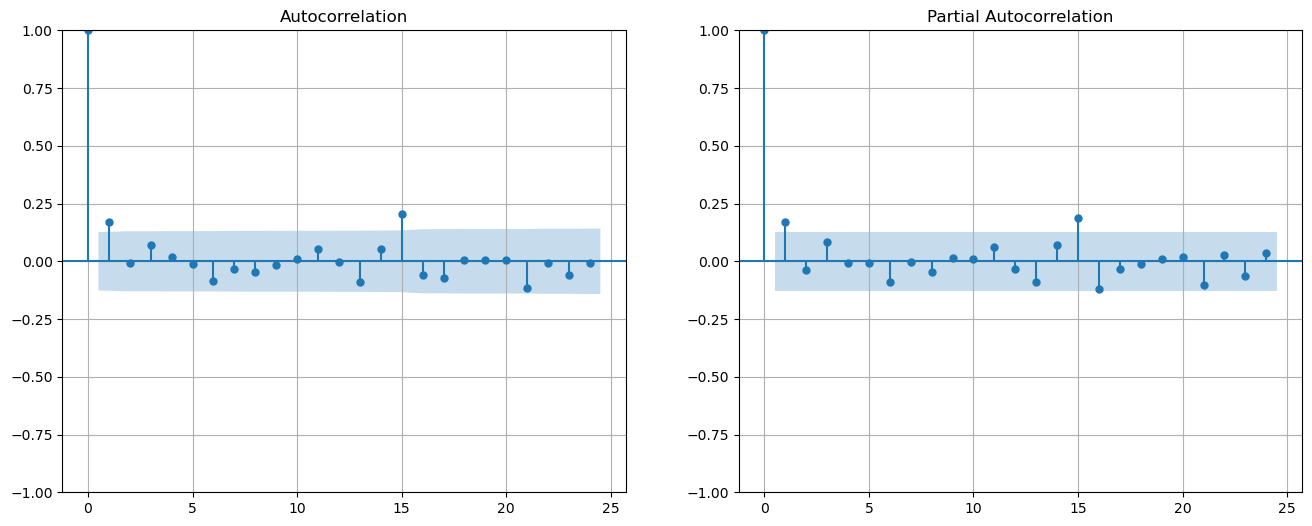

In [89]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff2, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff2, ax=axes[1])
axes[1].grid(True)
plt.show()

In [90]:
# Replace p, d, q with the values identified from ACF and PACF
model2 = ARIMA(train2, order=(5, 1, 1))
model_fit2 = model2.fit()

In [91]:
predict = model_fit2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [92]:
predict

2024-08-29    3712.676643
2024-08-30    3712.604610
2024-08-31    3712.795974
2024-09-01    3712.851769
2024-09-02    3712.843055
2024-09-03    3712.856146
2024-09-04    3712.862005
2024-09-05    3712.861247
2024-09-06    3712.862058
2024-09-07    3712.862626
2024-09-08    3712.862576
2024-09-09    3712.862619
2024-09-10    3712.862670
Freq: D, Name: predicted_mean, dtype: float64

In [93]:
# Calculate Mean Squared Error
mse2 = mean_squared_error(test2, predict)
print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 12.945020750972137


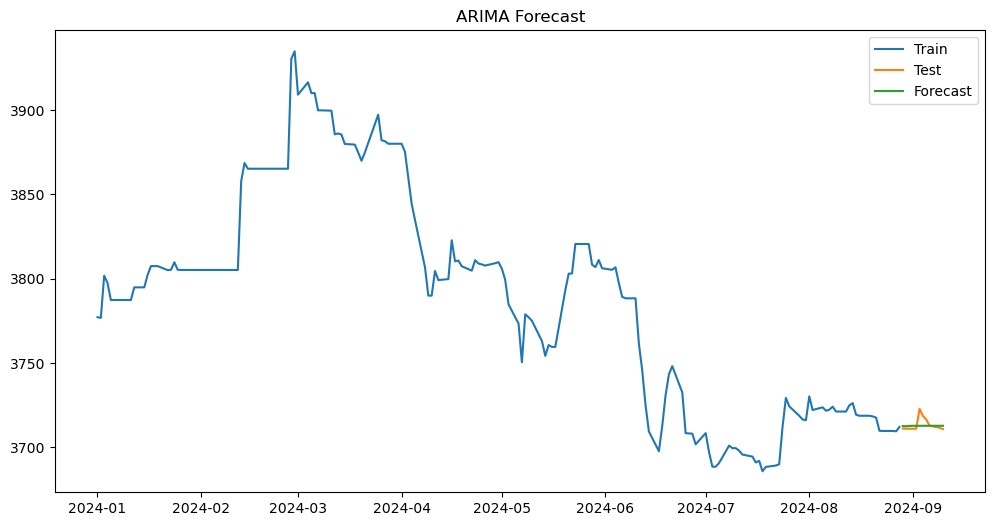

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [95]:
p,d,q = 1,1,1

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s2 = SARIMAX(train2, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted2 = model_s2.fit() 


In [97]:
# Get the predicted values
predict2 = fitted2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [98]:
predict2

2024-08-29    3711.784162
2024-08-30    3708.836128
2024-08-31    3708.675022
2024-09-01    3708.568957
2024-09-02    3708.394568
2024-09-03    3706.733231
2024-09-04    3710.043824
2024-09-05    3709.771110
2024-09-06    3706.794540
2024-09-07    3706.662038
2024-09-08    3706.550652
2024-09-09    3706.381984
2024-09-10    3704.749526
Freq: D, Name: predicted_mean, dtype: float64

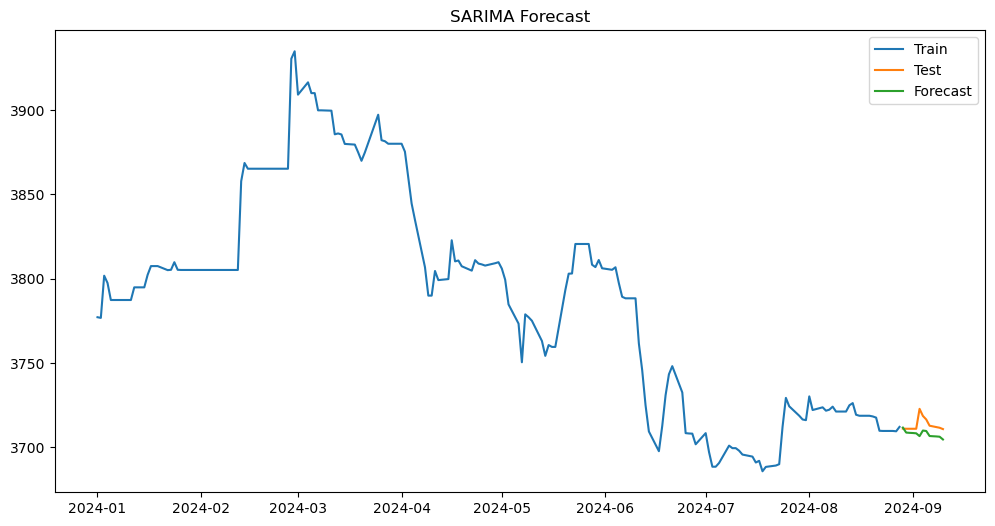

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [100]:
# Ensure 'Close' is a numpy array of the right shape
data2 = data2[['Close']].values

Data Preprocessing

In [102]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data2)

In [103]:
# Function to create sequences of data (X, y) pairs
def create_sequences(data2, time_step=60):
    X, y = [], []
    for i in range(len(data2) - time_step):
        X.append(data2[i:i + time_step, 0])
        y.append(data2[i + time_step, 0])
    return np.array(X), np.array(y)

In [104]:
# Define time step for the sequences
time_step = 60

In [105]:
# Create sequences
X, y = create_sequences(scaled_data, time_step)

In [106]:
# Reshape X to be [samples, time steps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [107]:

# Split data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [108]:
print("X_train shape is...", X_train.shape)
print("X_test shape is....", X_test.shape)
print("y_train shape is...", y_train.shape)
print("y_test shape is....", y_test.shape)

X_train shape is... (2003, 60, 1)
X_test shape is.... (501, 60, 1)
y_train shape is... (2003,)
y_test shape is.... (501,)


In [109]:
# Step 4: Create the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [111]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.1349 - val_loss: 0.0018
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0019 - val_loss: 7.4356e-04
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0010 - val_loss: 6.0535e-04
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 9.9538e-04 - val_loss: 7.9411e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 8.1272e-04 - val_loss: 5.1202e-04
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 8.4797e-04 - val_loss: 5.1122e-04
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 8.6639e-04 - val_loss: 6.3676e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 7.5514e-04 - val_loss: 4.4417e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0010 - val_loss: 5.0121e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.6243e-04 - val_loss: 4.1325e-04
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 7.2937e-04 - val_loss: 5.185

In [112]:
# Step 5: Make Predictions
predicted = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [113]:
# Inverse transform the predictions to original scale
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))

In [114]:
# Inverse transform the actual values for comparison
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

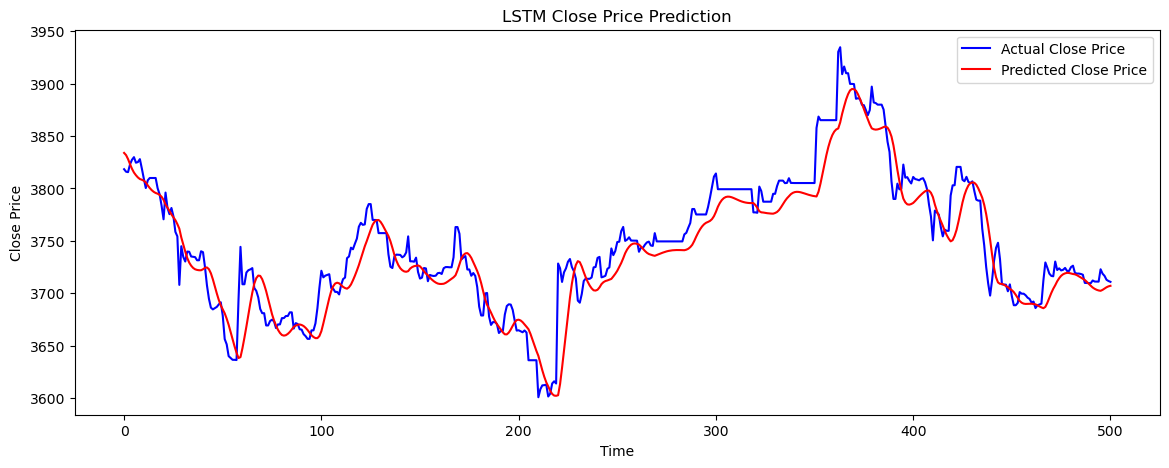

In [115]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test_scaled, color='blue', label='Actual Close Price')
plt.plot(predicted, color='red', label='Predicted Close Price')
plt.title('LSTM Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()